1. Import Lib
1. Import Dataset
1. Get Image and Label
1. Create Model
1. Train Model
1. Test Model

# Load Dataset

> Import Lib

In [1]:
import pandas as pd
import torch
import torchvision
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F

load label dataset

In [2]:
label_data = pd.read_csv("../../dataset/facelandmark/facial_keypoints.csv")
label_data = label_data.dropna()
label_index = label_data.index
full_label = label_data.values
label_data.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


load image dataset

In [3]:
image_data = np.load("../../dataset/facelandmark/face_images.npz")
image_data = image_data["face_images"]
image_data = np.transpose(image_data,(2,0,1))

full_image = np.expand_dims(image_data[label_index],1)


cleaning data

In [12]:
label_data = label_data.dropna()

split dataset to train and test

In [6]:
X_train,X_test,y_train,y_test = train_test_split(full_image,full_label,test_size = 0.1)

> Create class method for Face Dataset

In [4]:
class FaceDataset(torch.utils.data.Dataset):
    def __init__(self,image,label):
        self.image = image
        self.label = label
        
    def __len__(self):
        return len(self.image)
    
    def __getitem__(self,idx):
        image = self.image[idx] / 255.
        label = self.label[idx] / 96.
        
        image = torch.as_tensor(image,dtype = torch.float32)
        label = torch.as_tensor(label,dtype = torch.float32)
        
        return image,label
        
        

> test class method

> create dataset

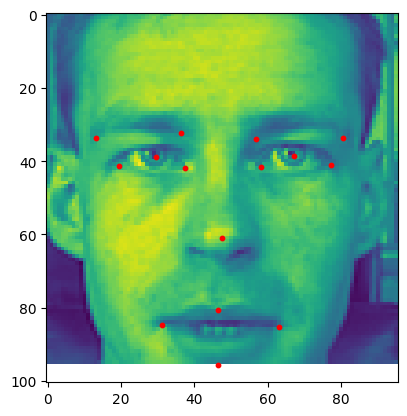

<Figure size 640x480 with 0 Axes>

In [7]:
test_image = FaceDataset(X_train,y_train)

def pltshower(image,label,idx):

    x = label[idx][1].reshape(15,2)[0:,0] *96
    y = label[idx][1].reshape(15,2)[0:,1] *96

    img = image[idx][0]
    img = np.transpose(img,(1,2,0))

    plt.imshow(img)

    plt.scatter(x,y,c = "red", s = 10)
    plt.figure()



for i in range(1):

    pltshower(test_image,test_image,i)



In [8]:
train_loader = torch.utils.data.DataLoader(FaceDataset(X_train,y_train),shuffle = True,batch_size = 32)
test_loader  = torch.utils.data.DataLoader(FaceDataset(X_test,y_test), shuffle = False, batch_size = 32)

# Model Part

> select device

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

> load model (our)

In [10]:
class ConvNet(nn.Module):
    def __init__(self,out_class):
        super(ConvNet,self).__init__()

        self.conv = nn.Conv2d(1,64,kernel_size = 3)
        self.batch = nn.BatchNorm2d(num_features = 64)
        self.rel = nn.ReLU()
        self.maxp = nn.MaxPool2d(kernel_size = 2)
        self.drop = nn.Dropout(0.2)

        self.conv2 = nn.Conv2d(64,128,kernel_size = 3)
        self.batch2 = nn.BatchNorm2d(num_features = 128)
        self.rel2 = nn.ReLU()
        self.maxp2 = nn.MaxPool2d(kernel_size = 2)
        self.drop2 = nn.Dropout(0.2)

        self.conv3 = nn.Conv2d(128,512,kernel_size = 3)
        self.batch3 = nn.BatchNorm2d(num_features = 512)
        self.rel3 = nn.ReLU()
        self.maxp3 = nn.MaxPool2d(kernel_size = 2)
        self.drop3 = nn.Dropout(0.2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512*10*10,1024)
        self.fc2 = nn.Linear(1024,512)
        self.out = nn.Linear(512,30)


    def forward(self,x):
        x = self.conv(x)
        x = self.batch(x)
        x = self.rel(x)
        x = self.maxp(x)
        x = self.drop(x)

        x = self.conv2(x)
        x = self.batch2(x)
        x = self.rel2(x)
        x = self.maxp2(x)
        x = self.drop2(x)

        x = self.conv3(x)
        x = self.batch3(x)
        x = self.rel3(x)
        x = self.maxp3(x)
        x = self.drop3(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = torch.sigmoid(self.out(x))

        return x
        
        

In [37]:
epoch = 100
model = ConvNet(30).to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr = 0.0001)
criterion = nn.L1Loss()



> train

In [38]:
test_loss_graph = []
train_loss_graph = []
for epochs in range(epoch):
    model.train()
    train_loss_inf = 0
    test_loss_inf = 0
    
    for image,label in train_loader:
        
        
        image,label = image.to(device),label.to(device)
        
        output = model(image)

        loss = criterion(output,label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss_inf += loss.item() * image.size(0)
    
    model.eval()
    for test_image,test_label in test_loader:
        test_image,test_label = test_image.to(device),test_label.to(device)
        
        output = model(test_image)

        test_loss = criterion(output,test_label)
        test_loss_inf += test_loss.item() * test_image.size(0)

    train_loss_graph.append(train_loss_inf / len(X_train)) 
    test_loss_graph.append(test_loss_inf / len(X_test))
    print(f"Epoch: {epochs}/{epoch} Train Loss: {train_loss_inf / len(X_train)}  Test Loss: {test_loss_inf / len(X_test)}")
    torch.save(model.state_dict(),"../../trainedmodel/model8.pt")
        

Epoch: 0/100 Train Loss: 0.3400787491726603  Test Loss: 0.3515553312880971
Epoch: 1/100 Train Loss: 0.347265392263359  Test Loss: 0.32555305540004625
Epoch: 2/100 Train Loss: 0.2720243514574453  Test Loss: 0.2247092237817907
Epoch: 3/100 Train Loss: 0.1978134490464459  Test Loss: 0.18106081510815664
Epoch: 4/100 Train Loss: 0.17203682498582798  Test Loss: 0.15787732378344668
Epoch: 5/100 Train Loss: 0.15611169444685288  Test Loss: 0.14094400531220658
Epoch: 6/100 Train Loss: 0.1405092083374164  Test Loss: 0.14148522774192773
Epoch: 7/100 Train Loss: 0.13076657720629672  Test Loss: 0.10509621721004771
Epoch: 8/100 Train Loss: 0.11022357635687445  Test Loss: 0.09656618549444965
Epoch: 9/100 Train Loss: 0.08776546981444859  Test Loss: 0.07216710137708165
Epoch: 10/100 Train Loss: 0.06276380377487972  Test Loss: 0.06152301532364337
Epoch: 11/100 Train Loss: 0.053579054641327506  Test Loss: 0.047027167002452866
Epoch: 12/100 Train Loss: 0.04164225314497205  Test Loss: 0.04420258909046093
Ep

# Visualize Prediiction

<Figure size 640x480 with 0 Axes>

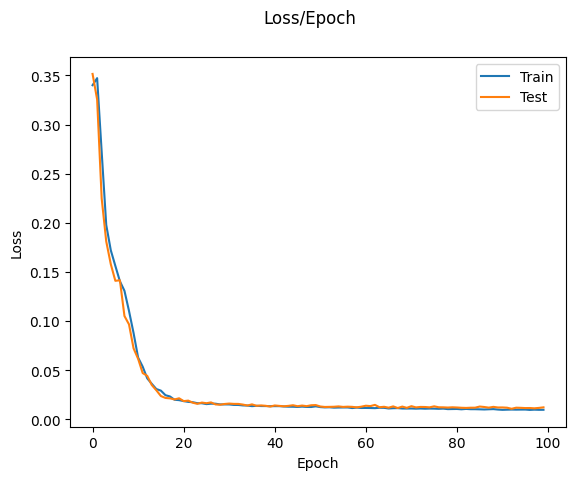

<Figure size 640x480 with 0 Axes>

In [39]:
plt.plot(train_loss_graph)
plt.plot(test_loss_graph)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.suptitle("Loss/Epoch")
plt.legend(["Train","Test"])
plt.figure()

> visualize model test

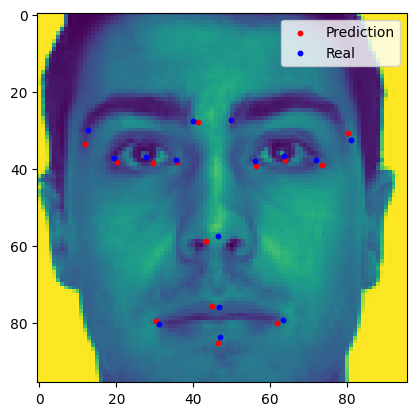

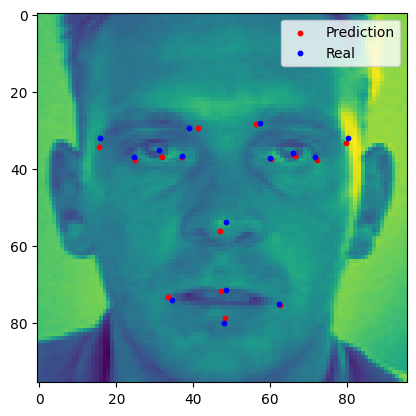

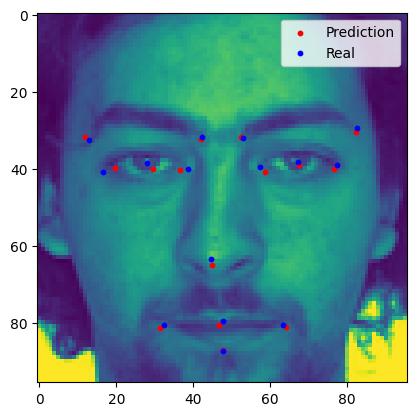

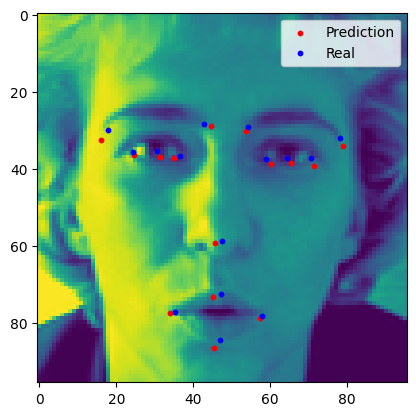

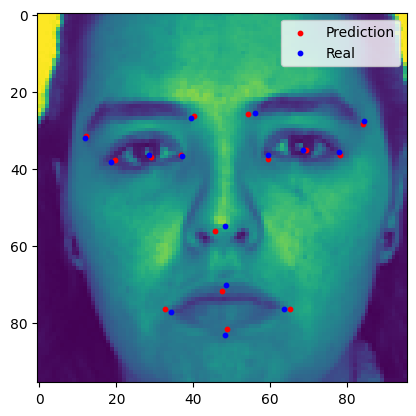

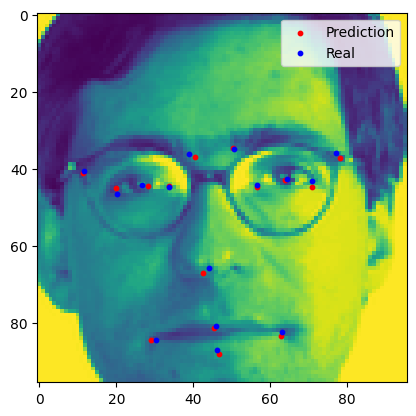

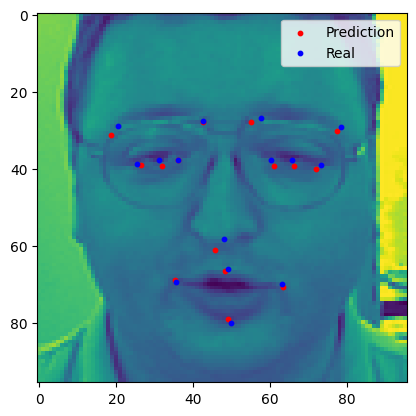

<Figure size 640x480 with 0 Axes>

In [11]:
model = ConvNet(30).to(device)
model.load_state_dict(torch.load('../../trainedmodel/model.pt'))
prediction_result = {}
model = model.to("cpu")

with torch.no_grad():

    model.eval()
    for i,(img,label) in enumerate(test_loader):
        output = model(img)

        output = output[i].reshape(15,2)
        real_label = label[i].reshape(15,2)

        # prediction_df = pd.DataFrame(output.reshape(30, 0))
        prediction_df = np.asarray(output.reshape(30, 1))
        prediction_result[i] = prediction_df



        image = img[i]
        image = np.transpose(image,(1,2,0))
        plt.imshow(image*255)
        plt.scatter(output[0:,0]*96,output[0:,1]*96,c="red",s = 10)

        plt.scatter(real_label[0:,0]*96,real_label[0:,1]*96,c="blue",s = 10)
        plt.legend(["Prediction","Real"])#blue : Prediction

        plt.figure()

# import csv
# with open('prediction.csv','w') as f1:
#     writer=csv.writer(f1, delimiter=',',lineterminator='\n',)
#     for key, row in prediction_result.items():
#         writer.writerow(iter(row))
